In [1]:
!pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu130

Looking in indexes: https://download.pytorch.org/whl/cu130, https://pypi.ngc.nvidia.com


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader

# Cihaz yapılandırması (GPU varsa kullan, yoksa CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Çalışma cihazı: {device}")

# Veri setini yükleme
df = pd.read_csv('NYC_Crash_Model_Final.csv')

# Sütun filtreleme işlemleri
hedef_sutunlar = ['LATITUDE', 'LONGITUDE', 'HOUR', 'IS_MULTI_VEHICLE']
extra_cols = [col for col in df.columns if 'VEHICLE_' in col or 'FACTOR_' in col]
hedef_sutunlar.extend(extra_cols)

if 'SEVERITY' in df.columns and 'SEVERITY' not in hedef_sutunlar:
    hedef_sutunlar.append('SEVERITY')

df_filtered = df[hedef_sutunlar].copy()

# Hedef değişken düzenlemesi
if 'SEVERITY' in df_filtered.columns:
    df_filtered['SEVERITY'] = df_filtered['SEVERITY'].replace(2, 1)

y = df_filtered['SEVERITY']
X = df_filtered.drop(columns=['SEVERITY']).astype('float32')

# Eğitim ve test setlerinin ayrılması
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Ölçeklendirme (Deep Learning için gereklidir)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

# Numpy dizilerini PyTorch tensörlerine dönüştürme
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).to(device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1).to(device)

# Özel Veri Seti Sınıfı
class CrashDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Veri Yükleyicileri (DataLoaders)
batch_size = 64
train_loader = DataLoader(CrashDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(CrashDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

print(f"Veri hazırlığı tamamlandı. Eğitim seti boyutu: {X_train_tensor.shape[0]}")

Çalışma cihazı: cuda
Veri hazırlığı tamamlandı. Eğitim seti boyutu: 1528858


In [3]:
import torch
import torch.nn as nn
import math

class DNNModel(nn.Module):
    def __init__(self, input_dim):
        super(DNNModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

class LSTMAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(LSTMAttention, self).__init__()
        
        # Çift yönlü (Bidirectional) LSTM
        self.lstm = nn.LSTM(1, hidden_dim, batch_first=True, bidirectional=True)
        
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.fc = nn.Linear(hidden_dim * 2, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = x.unsqueeze(-1)
        
        lstm_out, _ = self.lstm(x) 
        
        # Attention Hesaplaması
        attn_weights = torch.tanh(self.attention(lstm_out))
        attn_weights = torch.softmax(attn_weights, dim=1)
        
        context = torch.sum(attn_weights * lstm_out, dim=1)
        
        return self.sigmoid(self.fc(context))

class WideAndDeep(nn.Module):
    def __init__(self, input_dim):
        super(WideAndDeep, self).__init__()
        self.wide = nn.Linear(input_dim, 1)
        
        self.deep = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        wide_out = self.wide(x)
        deep_out = self.deep(x)
        return self.sigmoid(wide_out + deep_out)

# Özellikleri bir dizi gibi işler ve 'Self-Attention' kullanır.
class TabularTransformer(nn.Module):
    def __init__(self, input_dim, d_model=32, nhead=4, num_layers=2):
        super(TabularTransformer, self).__init__()
        
        self.feature_embedding = nn.Linear(1, d_model)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.fc = nn.Sequential(
            nn.Linear(input_dim * d_model, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        # Giriş
        # Dönüşüm
        x = x.unsqueeze(-1)
        x = self.feature_embedding(x)
        
        # Transformer'dan geçir
        x = self.transformer_encoder(x)
        
        # Düzleştir (Flatten) ve Sınıflandır
        x = x.reshape(x.size(0), -1)
        return self.fc(x)

In [4]:
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, classification_report
from time import time
import numpy as np

dl_results = []

def train_and_evaluate_dl(model, name, epochs=30):
    print(f"{name} modeli eğitiliyor...")
    start_time = time()
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_losses = []
    test_losses = []
    
    # Eğitim Süreci
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            out = model(X_batch)
            loss = criterion(out, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Doğrulama (Validation) Süreci
        model.eval()
        running_test_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                out = model(X_batch)
                loss = criterion(out, y_batch)
                running_test_loss += loss.item()
        
        avg_test_loss = running_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        
        if (epoch+1) % 2 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Eğitim Kaybı: {avg_train_loss:.4f} | Test Kaybı: {avg_test_loss:.4f}")

    total_time = time() - start_time
    
    # Final Değerlendirme
    model.eval()
    y_preds = []
    y_probs = []
    y_trues = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            out = model(X_batch)
            y_probs.extend(out.cpu().numpy())
            y_preds.extend((out > 0.5).float().cpu().numpy())
            y_trues.extend(y_batch.cpu().numpy())
            
    # Performans Metrikleri
    acc = accuracy_score(y_trues, y_preds)
    f1 = f1_score(y_trues, y_preds, average='weighted')
    auc = roc_auc_score(y_trues, y_probs)
    
    print(f"\nEğitim tamamlandı. Toplam Süre: {total_time:.2f} sn")
    print(f"AUC: {auc:.4f} | F1 Skoru: {f1:.4f} | Doğruluk: {acc:.4f}")
    
    # Detaylı Sınıflandırma Raporu
    print("\nDetaylı Sınıflandırma Raporu:")
    print(classification_report(y_trues, y_preds))
    
    dl_results.append({
        'Model': name, 
        'Accuracy': acc, 
        'AUC': auc, 
        'F1 Score': f1,
        'Duration': total_time
    })
    
    # Görselleştirme Paneli
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    
    # 1. Kayıp (Loss) Grafiği
    axs[0].plot(train_losses, label='Eğitim Kaybı')
    axs[0].plot(test_losses, label='Test Kaybı', linestyle='--')
    axs[0].set_title('Eğitim ve Test Kayıp Eğrisi', fontsize=12, fontweight='bold')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True, alpha=0.3)
    
    # 2. Confusion Matrix
    cm = confusion_matrix(y_trues, y_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axs[1], cbar=False)
    axs[1].set_title('Confusion Matrix', fontsize=12, fontweight='bold')
    axs[1].set_xlabel('Tahmin Edilen')
    axs[1].set_ylabel('Gerçek Değer')
    
    # 3. ROC Eğrisi
    fpr, tpr, _ = roc_curve(y_trues, y_probs)
    axs[2].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc:.3f}')
    axs[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axs[2].set_title('ROC Eğrisi', fontsize=12, fontweight='bold')
    axs[2].legend(loc="lower right")
    axs[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

Advanced DNN modeli eğitiliyor...
Epoch 2/30 - Eğitim Kaybı: 0.4942 | Test Kaybı: 0.4955
Epoch 4/30 - Eğitim Kaybı: 0.4927 | Test Kaybı: 0.4911
Epoch 6/30 - Eğitim Kaybı: 0.4919 | Test Kaybı: 0.4907
Epoch 8/30 - Eğitim Kaybı: 0.4915 | Test Kaybı: 0.4971
Epoch 10/30 - Eğitim Kaybı: 0.4913 | Test Kaybı: 0.4910
Epoch 12/30 - Eğitim Kaybı: 0.4911 | Test Kaybı: 0.4900
Epoch 14/30 - Eğitim Kaybı: 0.4909 | Test Kaybı: 0.4897
Epoch 16/30 - Eğitim Kaybı: 0.4908 | Test Kaybı: 0.4899
Epoch 18/30 - Eğitim Kaybı: 0.4908 | Test Kaybı: 0.4898
Epoch 20/30 - Eğitim Kaybı: 0.4907 | Test Kaybı: 0.4903
Epoch 22/30 - Eğitim Kaybı: 0.4906 | Test Kaybı: 0.4897
Epoch 24/30 - Eğitim Kaybı: 0.4906 | Test Kaybı: 0.4896
Epoch 26/30 - Eğitim Kaybı: 0.4906 | Test Kaybı: 0.4944
Epoch 28/30 - Eğitim Kaybı: 0.4905 | Test Kaybı: 0.4897
Epoch 30/30 - Eğitim Kaybı: 0.4904 | Test Kaybı: 0.4893

Eğitim tamamlandı. Toplam Süre: 1955.20 sn
AUC: 0.7083 | F1 Skoru: 0.7438 | Doğruluk: 0.7908

Detaylı Sınıflandırma Raporu:
     

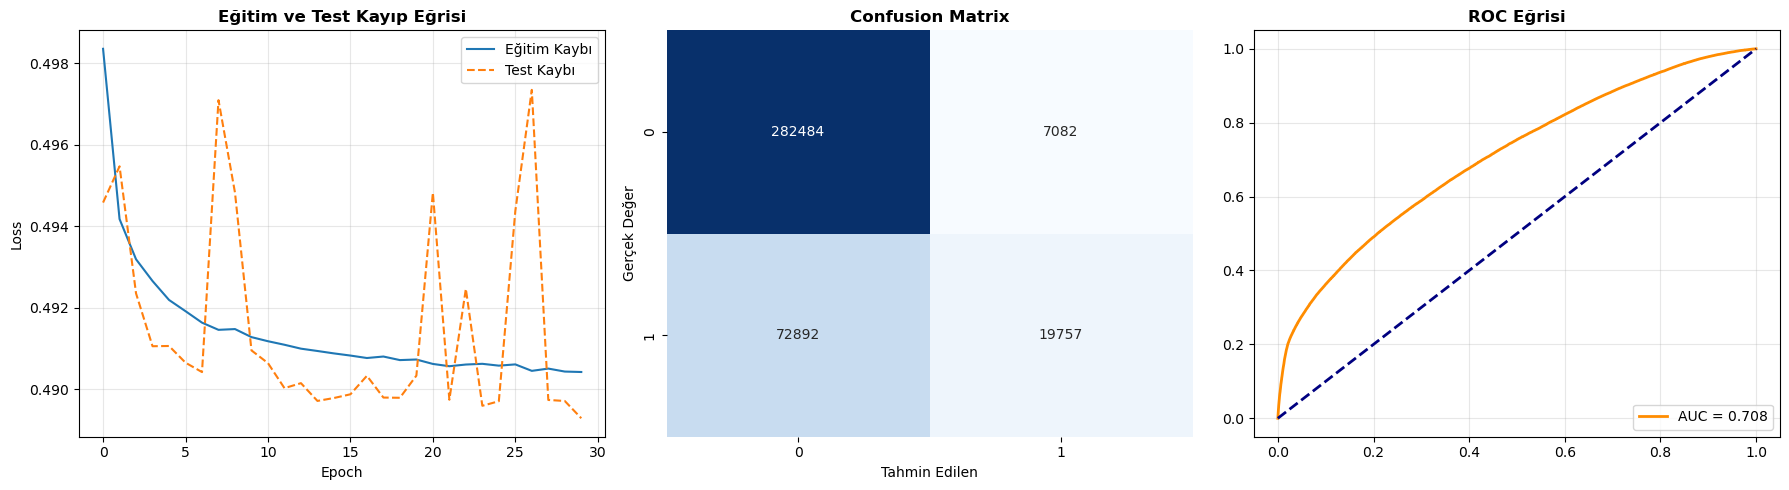

Bi-LSTM with Attention modeli eğitiliyor...
Epoch 2/30 - Eğitim Kaybı: 0.4914 | Test Kaybı: 0.4933
Epoch 4/30 - Eğitim Kaybı: 0.4888 | Test Kaybı: 0.4904
Epoch 6/30 - Eğitim Kaybı: 0.4875 | Test Kaybı: 0.4886
Epoch 8/30 - Eğitim Kaybı: 0.4867 | Test Kaybı: 0.4884
Epoch 10/30 - Eğitim Kaybı: 0.4862 | Test Kaybı: 0.4878
Epoch 12/30 - Eğitim Kaybı: 0.4858 | Test Kaybı: 0.4877
Epoch 14/30 - Eğitim Kaybı: 0.4857 | Test Kaybı: 0.4877
Epoch 16/30 - Eğitim Kaybı: 0.4855 | Test Kaybı: 0.4870
Epoch 18/30 - Eğitim Kaybı: 0.4849 | Test Kaybı: 0.4871
Epoch 20/30 - Eğitim Kaybı: 0.4847 | Test Kaybı: 0.4869
Epoch 22/30 - Eğitim Kaybı: 0.4864 | Test Kaybı: 0.4881
Epoch 24/30 - Eğitim Kaybı: 0.4847 | Test Kaybı: 0.4870
Epoch 26/30 - Eğitim Kaybı: 0.4841 | Test Kaybı: 0.4867
Epoch 28/30 - Eğitim Kaybı: 0.4839 | Test Kaybı: 0.4869
Epoch 30/30 - Eğitim Kaybı: 0.4837 | Test Kaybı: 0.4869

Eğitim tamamlandı. Toplam Süre: 2294.94 sn
AUC: 0.7136 | F1 Skoru: 0.7468 | Doğruluk: 0.7911

Detaylı Sınıflandırma Rap

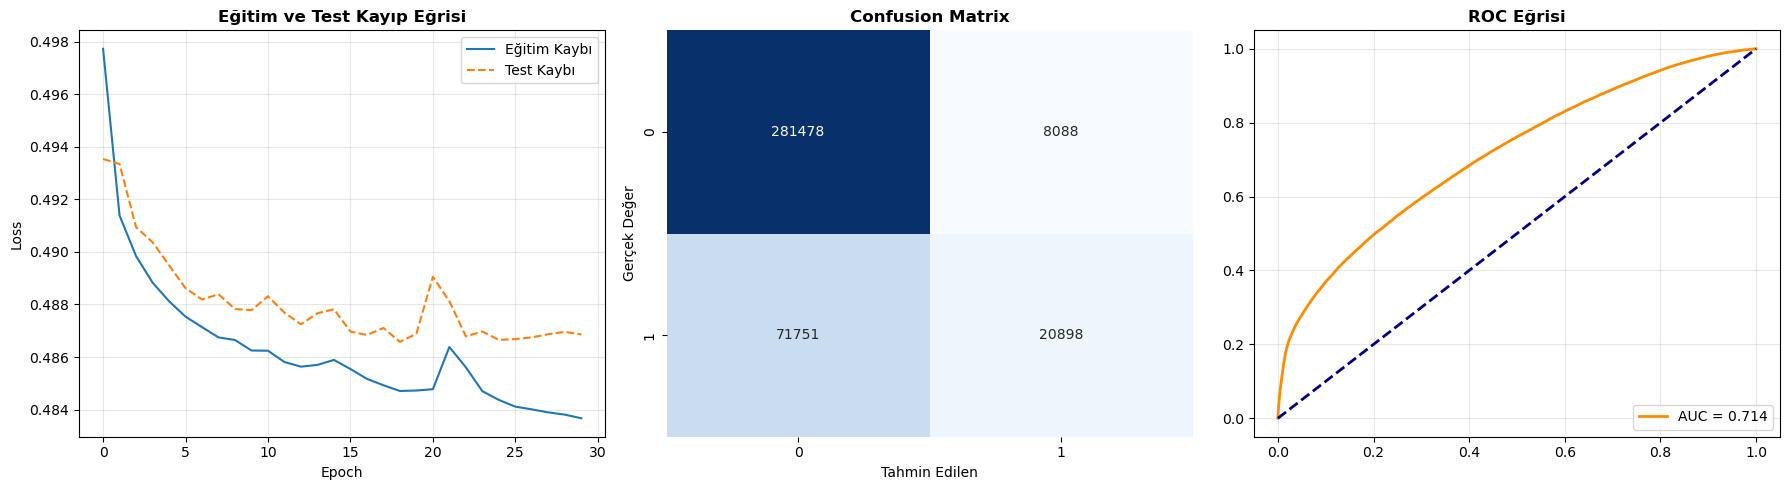

Wide & Deep Learning modeli eğitiliyor...
Epoch 2/30 - Eğitim Kaybı: 0.4945 | Test Kaybı: 0.4932
Epoch 4/30 - Eğitim Kaybı: 0.4923 | Test Kaybı: 0.4915
Epoch 6/30 - Eğitim Kaybı: 0.4913 | Test Kaybı: 0.4909
Epoch 8/30 - Eğitim Kaybı: 0.4911 | Test Kaybı: 0.4906
Epoch 10/30 - Eğitim Kaybı: 0.4908 | Test Kaybı: 0.4907
Epoch 12/30 - Eğitim Kaybı: 0.4908 | Test Kaybı: 0.4902
Epoch 14/30 - Eğitim Kaybı: 0.4906 | Test Kaybı: 0.4906
Epoch 16/30 - Eğitim Kaybı: 0.4905 | Test Kaybı: 0.4904
Epoch 18/30 - Eğitim Kaybı: 0.4903 | Test Kaybı: 0.4904
Epoch 20/30 - Eğitim Kaybı: 0.4903 | Test Kaybı: 0.4904
Epoch 22/30 - Eğitim Kaybı: 0.4903 | Test Kaybı: 0.4899
Epoch 24/30 - Eğitim Kaybı: 0.4903 | Test Kaybı: 0.4900
Epoch 26/30 - Eğitim Kaybı: 0.4902 | Test Kaybı: 0.4901
Epoch 28/30 - Eğitim Kaybı: 0.4902 | Test Kaybı: 0.4899
Epoch 30/30 - Eğitim Kaybı: 0.4902 | Test Kaybı: 0.4900

Eğitim tamamlandı. Toplam Süre: 1559.22 sn
AUC: 0.7062 | F1 Skoru: 0.7419 | Doğruluk: 0.7906

Detaylı Sınıflandırma Rapor

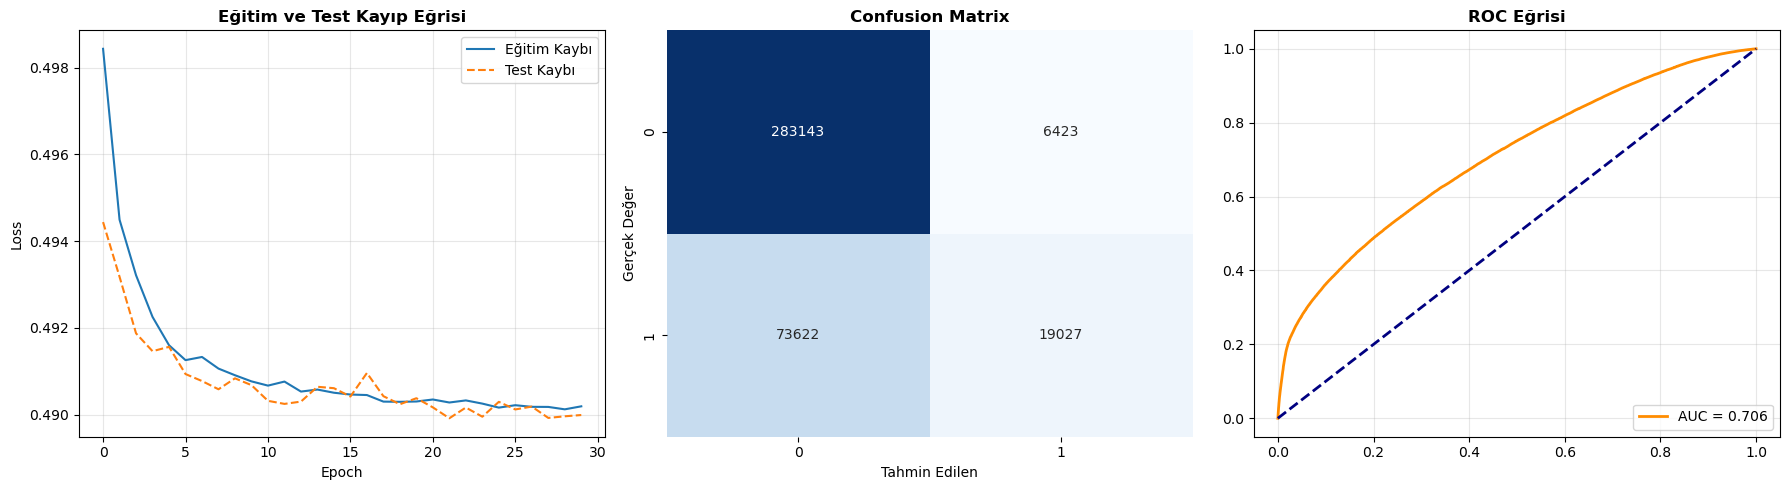

Tabular Transformer modeli eğitiliyor...
Epoch 2/30 - Eğitim Kaybı: 0.4944 | Test Kaybı: 0.4910
Epoch 4/30 - Eğitim Kaybı: 0.4929 | Test Kaybı: 0.4902
Epoch 6/30 - Eğitim Kaybı: 0.4925 | Test Kaybı: 0.4902
Epoch 8/30 - Eğitim Kaybı: 0.4924 | Test Kaybı: 0.4902
Epoch 10/30 - Eğitim Kaybı: 0.4918 | Test Kaybı: 0.4901
Epoch 12/30 - Eğitim Kaybı: 0.4915 | Test Kaybı: 0.4904
Epoch 14/30 - Eğitim Kaybı: 0.4915 | Test Kaybı: 0.4942
Epoch 16/30 - Eğitim Kaybı: 0.4914 | Test Kaybı: 0.4910
Epoch 18/30 - Eğitim Kaybı: 0.4914 | Test Kaybı: 0.4892
Epoch 20/30 - Eğitim Kaybı: 0.4913 | Test Kaybı: 0.4894
Epoch 22/30 - Eğitim Kaybı: 0.4917 | Test Kaybı: 0.4892
Epoch 24/30 - Eğitim Kaybı: 0.4913 | Test Kaybı: 0.4901
Epoch 26/30 - Eğitim Kaybı: 0.4911 | Test Kaybı: 0.4900
Epoch 28/30 - Eğitim Kaybı: 0.4911 | Test Kaybı: 0.4891
Epoch 30/30 - Eğitim Kaybı: 0.4910 | Test Kaybı: 0.4894

Eğitim tamamlandı. Toplam Süre: 5642.23 sn
AUC: 0.7087 | F1 Skoru: 0.7424 | Doğruluk: 0.7905

Detaylı Sınıflandırma Raporu

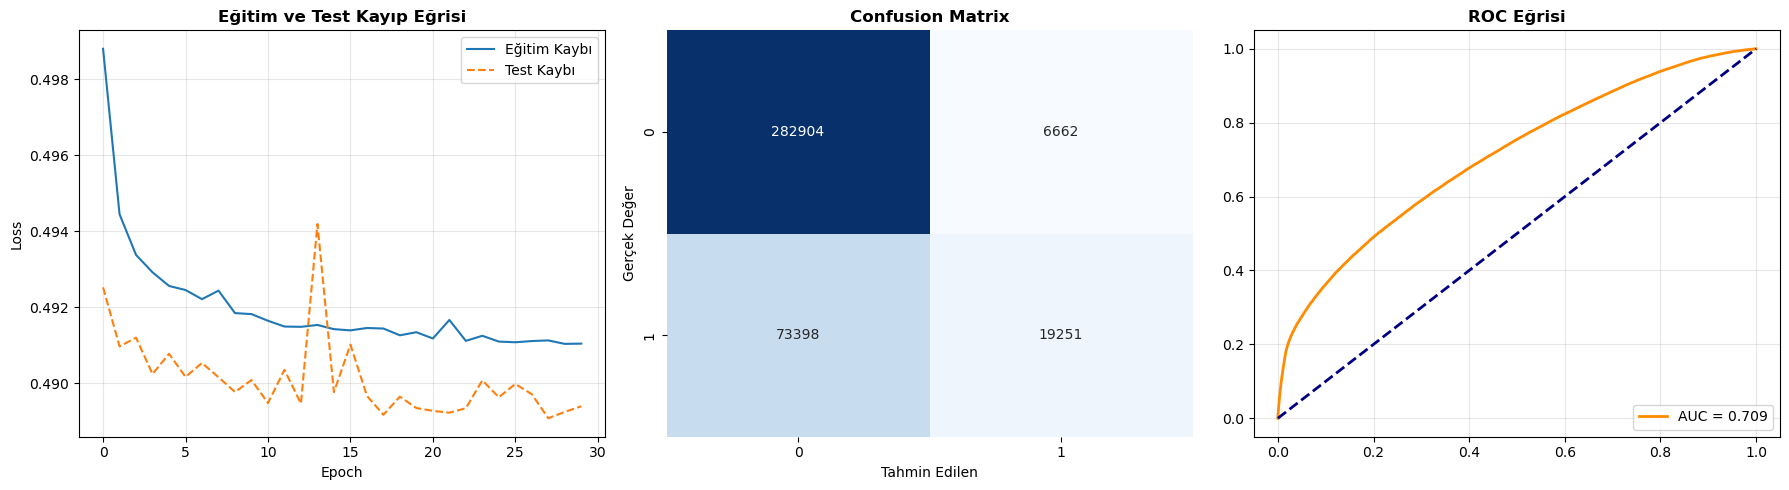


DERİN ÖĞRENME MODELLERİ KARŞILAŞTIRMA TABLOSU
                    Model  Accuracy       AUC  F1 Score     Duration
0  Bi-LSTM with Attention  0.791115  0.713631  0.746794  2294.938612
1     Tabular Transformer  0.790537  0.708676  0.742407  5642.230381
2            Advanced DNN  0.790762  0.708290  0.743816  1955.203092
3    Wide & Deep Learning  0.790576  0.706199  0.741881  1559.220303


C:\Users\umutk\AppData\Local\Temp\ipykernel_16340\2764605731.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='AUC', y='Model', data=results_df, palette='viridis')
C:\Users\umutk\AppData\Local\Temp\ipykernel_16340\2764605731.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Duration', y='Model', data=df_duration, palette='Reds')


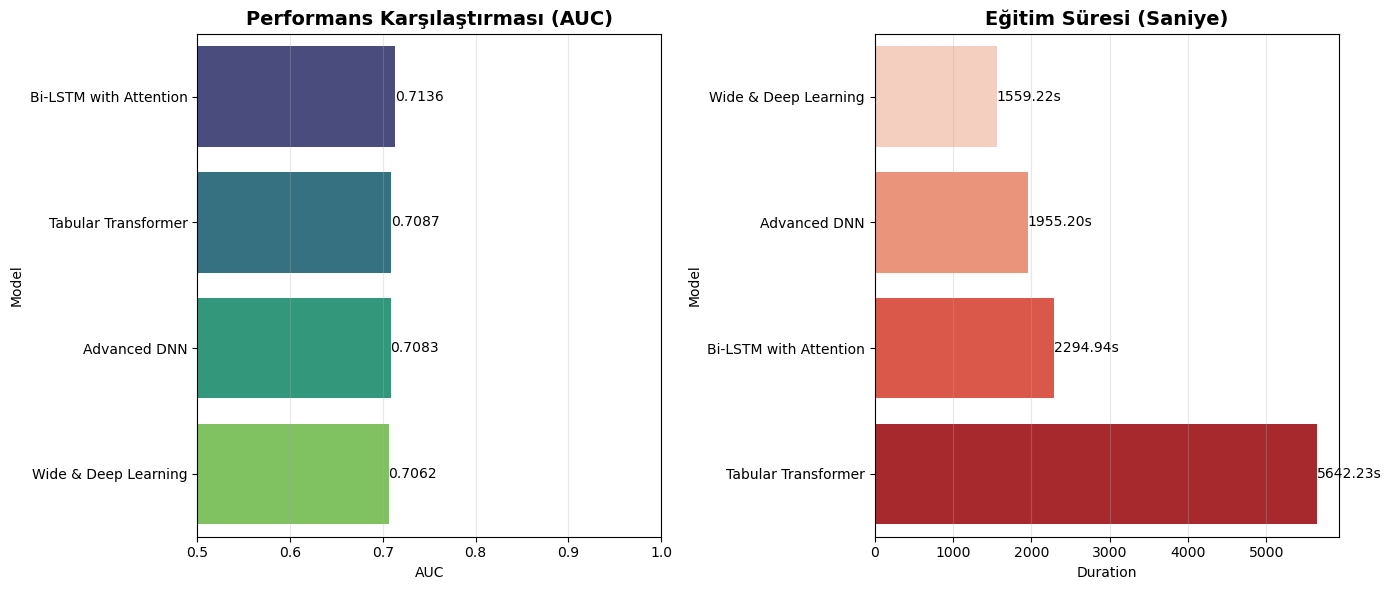


FİNAL SONUCU:
Test edilen derin öğrenme modelleri arasında en yüksek performansı Bi-LSTM with Attention gösterdi.
En İyi AUC Skoru: 0.7136


In [5]:
input_dim = X_train_raw.shape[1]

# 1. Gelişmiş DNN (Advanced DNN)
model_dnn = DNNModel(input_dim).to(device)
train_and_evaluate_dl(model_dnn, name="Advanced DNN", epochs=30)

# 2. Bidirectional LSTM + Attention
model_lstm = LSTMAttention(input_dim).to(device)
train_and_evaluate_dl(model_lstm, name="Bi-LSTM with Attention", epochs=30)

# 3. Wide & Deep Learning
model_wd = WideAndDeep(input_dim).to(device)
train_and_evaluate_dl(model_wd, name="Wide & Deep Learning", epochs=30)

# 4. Tabular Transformer
model_transformer = TabularTransformer(input_dim).to(device)
train_and_evaluate_dl(model_transformer, name="Tabular Transformer", epochs=30)

# Sonuçları DataFrame'e çevir
results_df = pd.DataFrame(dl_results).sort_values(by='AUC', ascending=False).reset_index(drop=True)

print("\nDERİN ÖĞRENME MODELLERİ KARŞILAŞTIRMA TABLOSU")
print(results_df.to_string())

# Karşılaştırma Grafikleri
plt.figure(figsize=(14, 6))

# 1. Grafik: AUC Skoru
plt.subplot(1, 2, 1)
sns.barplot(x='AUC', y='Model', data=results_df, palette='viridis')
plt.title('Performans Karşılaştırması (AUC)', fontsize=14, fontweight='bold')
plt.xlim(0.5, 1.0)
plt.grid(axis='x', alpha=0.3)
for index, value in enumerate(results_df['AUC']):
    plt.text(value, index, f'{value:.4f}', va='center')

# 2. Grafik: Eğitim Süresi
plt.subplot(1, 2, 2)
df_duration = results_df.sort_values(by='Duration')
sns.barplot(x='Duration', y='Model', data=df_duration, palette='Reds')
plt.title('Eğitim Süresi (Saniye)', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
for index, value in enumerate(df_duration['Duration']):
    plt.text(value, index, f'{value:.2f}s', va='center')

plt.tight_layout()
plt.show()

# Final Yorumu
best_model = results_df.iloc[0]
print(f"\nFİNAL SONUCU:")
print(f"Test edilen derin öğrenme modelleri arasında en yüksek performansı {best_model['Model']} gösterdi.")
print(f"En İyi AUC Skoru: {best_model['AUC']:.4f}")